In [4]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import glob
from scipy import stats
import re

# %matplotlib widget 
%matplotlib inline

dir_setup = '/p/scratch/cjibg36/kaandorp2/TSMP/tsmp_cordex_test'
pffiles = glob.glob(os.path.join(dir_setup,'input/parflow/*.sa'))


In [5]:
pffiles

['/p/scratch/cjibg36/kaandorp2/TSMP/tsmp_cordex_test/input/parflow/slopey.sa',
 '/p/scratch/cjibg36/kaandorp2/TSMP/tsmp_cordex_test/input/parflow/slopex.sa',
 '/p/scratch/cjibg36/kaandorp2/TSMP/tsmp_cordex_test/input/parflow/parflow_436x424x15_cosmomask_indicator_FAOonly.sa']

In [33]:
def read_pffile(file):
    with open(file) as f:
        nx, ny, nz = [int(x) for x in next(f).split()] # read first line

        array = []
        for i1,line in enumerate(f): # read rest of lines
            array.append(float(line))

    data = np.array(array).reshape([nz,ny,nx])    
    return data

slopex = read_pffile( glob.glob(os.path.join(dir_setup,'input/parflow/*slopex.sa'))[0] )
slopey = read_pffile( glob.glob(os.path.join(dir_setup,'input/parflow/*slopey.sa'))[0] )
mask = read_pffile( glob.glob(os.path.join(dir_setup,'input/parflow/*FAOonly.sa'))[0] )



array([ 1.,  2.,  3.,  4.,  6.,  7.,  9., 11., 12., 13., 14., 15., 16.])

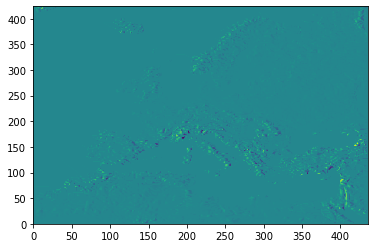

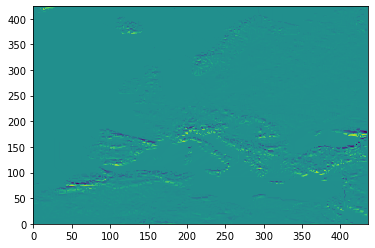

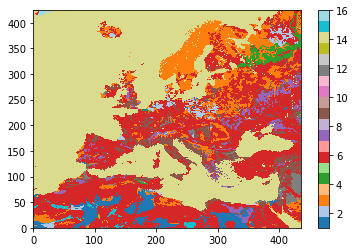

In [36]:
plt.figure()
plt.pcolormesh(slopex[0,:,:])


plt.figure()
plt.pcolormesh(slopey[0,:,:])


plt.figure()
plt.pcolormesh(mask[0,:,:],cmap=plt.cm.tab20)
plt.colorbar()

np.unique(mask)